# Masks

DragonDiffusion relies on **masks** that select parts of an image to apply transformations to. However, it's not clear from the paper how the masks are being generated, which is an odd omission. Unless they are user-provided, making masks is non-trivial — [DiffEdit](https://arxiv.org/abs/2210.11427) is one strategy for making masks purely within the paradigm of 'text-to-image', as is [Segment Anything](https://arxiv.org/abs/2304.02643). 

My assumption is that the authors are using something like this, or masks are being drawn freehand via a UI. The actual use case for this would likely be inside of a professional editor where there are degrees of freedom with modes of user interaction, and this work was sponsored by Tencent — it's possible that they are using some kind of interactive method. However, I'm not going to try to do that inside of a notebook. Technically, the masking strategy can be considered as a separate component and this method will work regardless of how the mask is created. But obviously the method is bound to some extent by the accuracy of the mask, so bear this in mind throughout. 

I'm going to try both DiffEdit and SegmentAnything, and see how we get on.

In [ ]:
#| default_exp masks

In [ ]:
#| export
from __future__ import annotations
import math, random, torch, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, shutil, os, gzip, pickle, re, copy
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
from functools import partial
import fastcore.all as fc
from glob import glob

from torch import tensor, nn, optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from diffusers import UNet2DModel
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from diffusers import LMSDiscreteScheduler, UNet2DConditionModel, AutoencoderKL
from transformers import AutoTokenizer, CLIPTextModel

from einops import rearrange
from fastprogress import progress_bar
from PIL import Image
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms
import cv2 as cv

from dragon_diffusion.core import *

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

In [ ]:
model = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='unet').cuda()
tokenizer = AutoTokenizer.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='vae').to('cuda')
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

In [ ]:
#| export
def get_embeddings(prompt, text_encoder, tokenizer, concat_unconditional=False, device='cpu'):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    max_length = text_input.input_ids.shape[-1]
    with torch.no_grad():
        embeds = text_encoder(text_input.input_ids)[0]
        if concat_unconditional:
            uncond_input = tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt")
            uncond_embeddings = text_encoder(uncond_input.input_ids)[0]
            embeds = torch.cat([uncond_embeddings, embeds])
    return embeds.to(device)

In [ ]:
#| export
def sample_original(prompt, text_encoder, tokenizer, seed=None, height=512, width=512, steps=50, guidance_scale=5, device='cuda'):
    if seed is None: seed = int(torch.rand((1,)) * 1000000)
    embeddings = get_embeddings(prompt, text_encoder, tokenizer, concat_unconditional=True, device=device)
    scheduler.set_timesteps(steps)
    shape = (1, model.in_channels, height // 8, width // 8)
    latents = torch.randn(shape, generator=torch.manual_seed(seed)).to(device)
    latents = latents * scheduler.init_noise_sigma
    
    for i, t in enumerate(progress_bar(scheduler.timesteps, leave=False)):
        latent_model_input = torch.cat([latents] * 2).to(device)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        with torch.no_grad():
            noise_pred = model(latent_model_input, t, encoder_hidden_states=embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
    latents = 1 / 0.18215 * latents
    with torch.no_grad(): image = vae.decode(latents).sample
    return image

In [ ]:
#| export
def process(image): return (image.clip(-1,1) + 1) / 2

In [ ]:
#| export
def to_pil(image):
    image = (image.clip(-1,1) + 1) / 2 * 255
    return Image.fromarray(image.cpu().permute(1,2,0).numpy().astype('uint8'))

In [ ]:
prompt = 'an astronaut floating above earth'
image = sample_original(prompt, text_encoder, tokenizer, seed=1)

/tmp/ipykernel_537/3495296012.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (1, model.in_channels, height // 8, width // 8)


<Axes: >

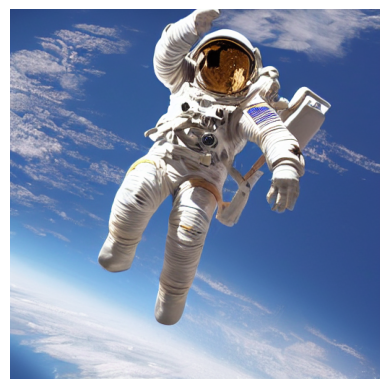

In [ ]:
show_image(process(image[0]))

### DiffEdit

In [ ]:
#| export
def encode_text(prompt, text_encoder):
    tokens = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    embedding = text_encoder(tokens.input_ids)[0]
    return embedding

In [ ]:
#| export
def encode_img(file_path, height, width, vae, device='cuda', concat=None):
    img = load_img(file_path, height, width)
    im_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
    if concat: im_tensor = torch.cat([im_tensor]*concat, dim=1)
    latents = vae.encode(im_tensor * 2 - 1).latent_dist.sample()
    return latents * 0.18215

In [ ]:
#| export
def return_mask_img(mask):
    im = (mask * 255.).round().astype("uint8")
    return Image.fromarray(im).resize((512, 512))

In [ ]:
#| export
def load_img(file_path, height, width, return_tensor=False, device='cpu'):
    image = Image.open(file_path).resize((height, width))
    if return_tensor: return transforms.ToTensor()(image).to(device)
    return image

In [ ]:
#| export
def decode_img(latent, vae):
    if not latent.device == vae.device: latent = latent.to(vae.device)
    with torch.no_grad():
        img = vae.decode(1 / 0.18215 * latent).sample
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).float().numpy()
    img = (img * 255).round().astype("uint8")
    return Image.fromarray(img[0])

In [ ]:
#| export
def sample_with_img(prompt, img_path, text_encoder, tokenizer, model, scheduler, vae, seed=None, height=512, width=512, steps=50, guidance_scale=5, device='cuda', compute_mask=False, start_step=0):
    
    if seed is None: seed = int(torch.rand((1,)) * 1000000)
    embeddings = get_embeddings(prompt, text_encoder, tokenizer, concat_unconditional=True, device=device)
    scheduler.set_timesteps(steps)
    
    shape = (1, model.in_channels, height // 8, width // 8)
    init_latents = encode_img(img_path, height, width, vae)
    scheduler.set_timesteps(steps)
    noise = torch.randn(shape).to('cuda') * 0.5
    latents = scheduler.add_noise(
        init_latents,
        noise,
        timesteps=torch.tensor([scheduler.timesteps[start_step]])
    )
    
    for i, t in enumerate(progress_bar(scheduler.timesteps, leave=False)):
        if i > start_step:
            latent_model_input = torch.cat([latents] * 2).to(device)
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            with torch.no_grad():
                noise_pred = model(latent_model_input, t, encoder_hidden_states=embeddings).sample

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            latents = scheduler.step(noise_pred, t, latents).prev_sample
        
    image = decode_img(latents, vae)
    if compute_mask: return latents.detach().cpu()
    return image

In [ ]:
#| export
def compute_mask(edit_text, ref_text, img, text_encoder, tokenizer, model, scheduler, vae, steps=70, guidance_scale=5, start_step=25, n=10):
    
    diffs = []
    
    for i in progress_bar(range(n)):
        e_pred = sample_with_img(edit_text, img, text_encoder, tokenizer, model, scheduler, vae, steps=steps, seed=i, start_step=start_step, compute_mask=True)[0]
        r_pred = sample_with_img(ref_text, img, text_encoder, tokenizer, model, scheduler, vae, steps=steps, seed=i, start_step=start_step, compute_mask=True)[0]
        distance = np.array(e_pred) - np.array(r_pred)
        diffs.append(distance)
        
    mask = np.zeros_like(diffs[0])
    for diff in diffs: mask += np.abs(diff)
        
    mask = mask.mean(0)
    mask = (mask - mask.mean()) / np.std(mask)
    mask[mask > 0.5] = 1
    mask[mask < 0] = 0
    
    return mask

In [ ]:
#| export
def improve_mask(image, mask):
    # image = cv2.imread(p) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 45, 0)    
    se = np.ones((0,0), dtype='uint8')
    image_close = cv2.morphologyEx(image, cv2.MORPH_CLOSE, se)
    image_close = abs(image_close - 255)
    
    
    nmask = np.minimum(1.0,mask + image_close)
    nmask = abs(nmask - 255)
    nmask = abs((abs(cv2.blur(nmask, (10, 10)) - 255) > 0) * 255 - 255)
    return nmask

In [ ]:
#| export
def improve_mask_2(mask_path, erosion_it=10, dilation_it=16):
    img = cv.imread(mask_path, 0)
    kernel = np.ones((3,3),np.uint8)
    erosion = cv.erode(img,kernel,iterations=erosion_it)
    mask = cv.dilate(erosion,kernel,iterations = dilation_it)
    mask_im = Image.fromarray(mask).resize((64, 64))
    mask = np.array(mask_im)
    mask[mask > 0] = 1
    mask[mask <= 0] = 0
    return mask

In [ ]:
#| export
def plot_images(init_img, mask_img):
    
    init_img = Image.open(init_img).resize((512, 512))
    
    # set up axes
    fig, axs = plt.subplots(1, 3, figsize=(18, 12))
    
    # initial image
    axs[0].imshow(init_img)
    axs[0].set_title(f"Initial image")
    
    # mask 
    axs[1].imshow(mask_img)
    axs[1].set_title(f"Mask")
    
    # mask overlay
    axs[2].imshow(np.array(init_img), cmap='gray') 
    axs[2].imshow(
        mask_img.resize((512, 512)),
        cmap='cividis', 
        alpha=0.5 
    )
    axs[2].set_title(f"Mask overlay")

In [ ]:
#| export
def diffedit_mask(edit_text, ref_text, img, n=10, seed=None, erosion_it=10, dilation_it=16):
    
    # compute mask
    mask = compute_mask(edit_text, ref_text, img, text_encoder, tokenizer, model, scheduler, vae, n=n, start_step=25, steps=50)
    mask_img = return_mask_img(mask)
    mask_path = "/home/mask.jpg"
    mask_img.save(mask_path, 0)
    
    # improve mask
    mask = improve_mask_2(mask_path, erosion_it=erosion_it, dilation_it=dilation_it)
    mask_img = return_mask_img(mask)
    mask_img.save(mask_path)
    plot_images(img, mask_img)
    
    return 

The idea with DiffEdit is that masks are calculated by averaging the difference in images generated with two prompts — one containing the 'real' word, and the other containing an edited word. The area that contains the difference between the two is extracted as a mask. Note below I have imaginatively replaced 'astronaut' with 'goat'.

/tmp/ipykernel_209/1003757327.py:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (1, model.in_channels, height // 8, width // 8)


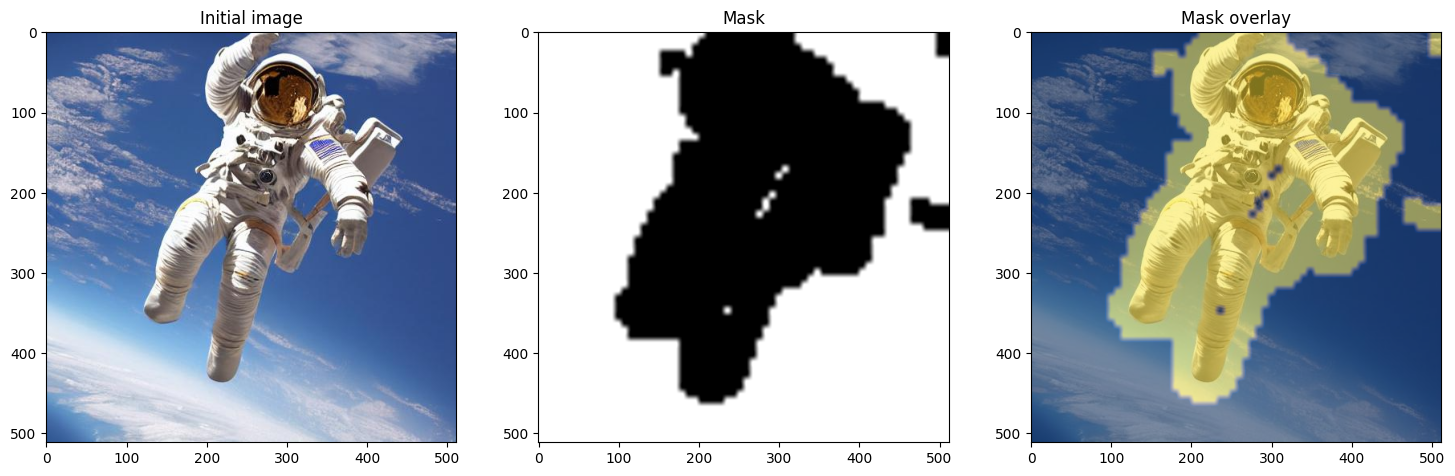

In [ ]:
img = '/home/astronaut.jpg'
edit_text = 'a goat floating above earth'
ref_text = 'an astronaut floating above earth'
diffedit_mask(edit_text, ref_text, img, seed=42, erosion_it=8, dilation_it=14)

That's not a *terrible* attempt. There's some padding around the shape which will probably help with blending/inpainting. It's not amazing though (for example, there's some bits missing in the middle, and some random squares), and it's pretty (very) slow. There's probably some optimisations you could make to improve this. The good thing is that it's pretty lightweight without leaning on any external models. Maybe that's useful to you, and this may also come in handy later on depending on how things go.

I don't know yet whether the masks need to be calculated **per diffusion step** — if there are 50 diffusion steps, calculating this mask is going to be very cumbersome and probably not realistic as a solution. The other idea I had was SegmentAnything, which is Facebook's new segmentation model. This will probably be a lot more powerful, though it does mean downloading more model weights which is a pain.

### SegmentAnything

This code is just taken from Facebook's [Segment Anything](https://github.com/facebookresearch/segment-anything/tree/main) repo.

In [ ]:
#| export
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [ ]:
#| export
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [ ]:
image = cv.imread('/home/astronaut.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

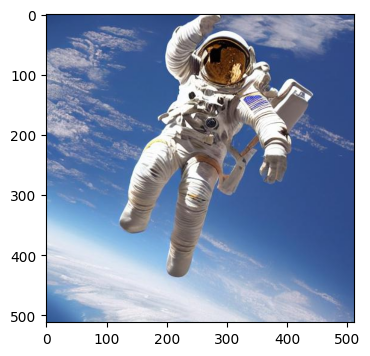

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(image)
plt.axis('on')
plt.show()

Awaiting model download... 

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
device='cuda'

sam_checkpoint = "/home/models/foundation/segment_anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

In [ ]:
predictor.set_image(image)

In [ ]:
input_point = np.array([[250, 200]])
input_label = np.array([1])

In [ ]:
mask, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

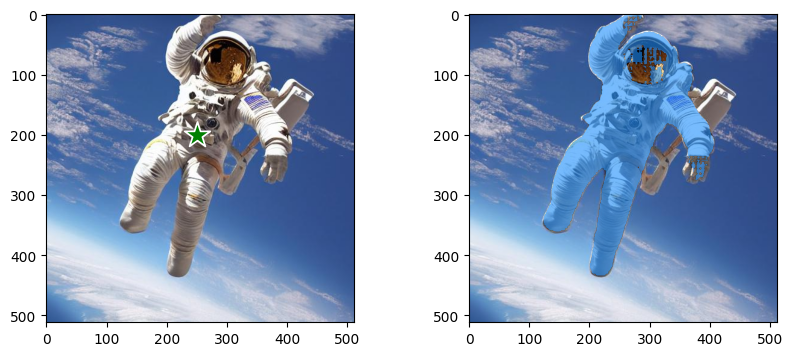

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
show_points(input_point, input_label, ax[0])
ax[0].imshow(image)
ax[1].imshow(image)
show_mask(mask[2], ax[1])

In [ ]:
input_point = np.array([[350, 150]])
input_label = np.array([1])
mask, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

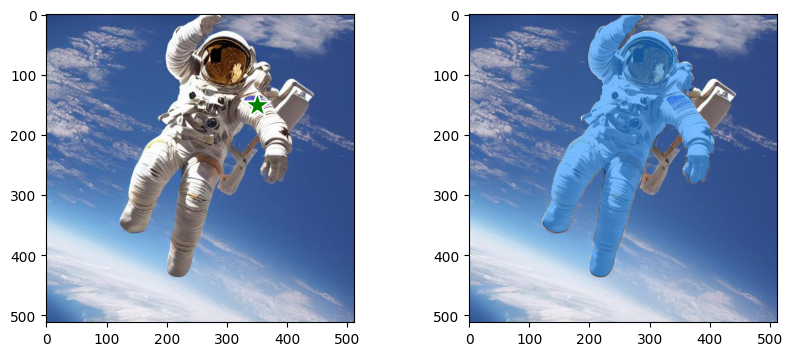

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
show_points(input_point, input_label, ax[0])
ax[0].imshow(image)
ax[1].imshow(image)
show_mask(mask[2], ax[1])

In [ ]:
#| export
def get_sam_predictor(ckpt_path:str, model_type:str, device:str='cuda'):
    """Returns a SAM predictor object."""
    sys.path.append("..")
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device)
    return SamPredictor(sam)

In [ ]:
#| export
def get_sam_mask(image, predictor, input_point: List[List[int]], plot=False):
    """Returns a set of predicted masks for a single input point."""
    input_point = np.array([input_point[0]])
    input_label = np.array([1])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    if len(input_point) > 1:
        input_point = np.array(input_point)
        mask_input = logits[np.argmax(scores), :, :]
        input_label = np.array([1,1])
        masks, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            mask_input=mask_input[None, :, :],
            multimask_output=True,
        )
    if plot:
        fig, ax = plt.subplots(1,len(masks)+1, figsize=(12,4))
        show_points(input_point, input_label, ax[0])
        ax[0].imshow(image)
        for i in range(1, len(masks) + 1):
            ax[i].imshow(image)
            show_mask(masks[i-1], ax[i])
    return masks

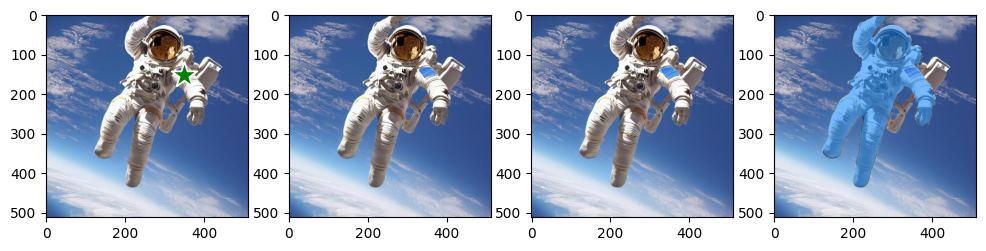

In [ ]:
masks = get_sam_mask(image, predictor, [[350,150]], plot=True)

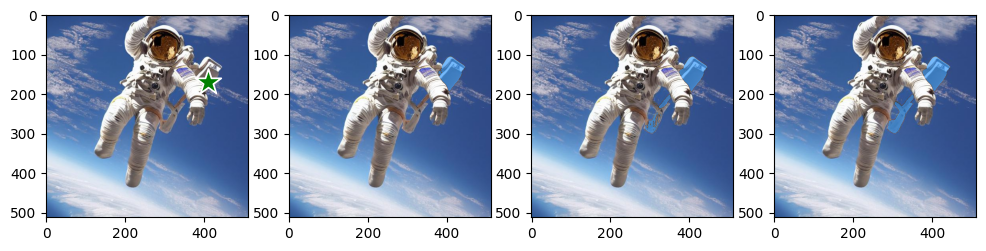

In [ ]:
masks = get_sam_mask(image, predictor, [[410,170],[180,250]], plot=True)

That mask is definitely cleaner, easier to use and much faster. Probably should have done that first.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()